<a href="https://colab.research.google.com/github/eshal26/PCA-CNN/blob/main/resnet_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import shutil
import sklearn
from sklearn.model_selection import train_test_split

In [3]:
train_dir = 'train_dataset'
val_dir = 'validation_dataset'
test_dir = 'test_dataset'

# Define transformations for training, validation, and testing data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.8245, 0.8547, 0.9387], std = [0.1323, 0.1431, 0.0530])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.8245, 0.8547, 0.9387], std = [0.1323, 0.1431, 0.0530])
])

# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
from sklearn.decomposition import PCA
import numpy as np

# Define BasicBlock
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Adjust shortcut to match dimensions if needed
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        shortcut = self.shortcut(x)
        out += shortcut
        out = self.relu(out)
        return out

# Define SimpleResNetWithPCA
class SimpleResNetWithPCA(nn.Module):
    def __init__(self, num_classes=2, pca_components=32, pca=None):
        super(SimpleResNetWithPCA, self).__init__()

        # First Residual Block
        self.layer1 = BasicBlock(3, 64)

        # Second Residual Block
        self.layer2 = BasicBlock(64, 128)

        self.relu = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)

        # PCA Parameters
        self.pca = pca  # Accept PCA instance externally or set to None
        self.pca_components = pca_components

        # Pooling and Fully Connected Layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(pca_components, 32)  # Adjusted input features after PCA
        self.fc2 = nn.Linear(32, num_classes)

    def extract_features(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten before PCA
        return x

    def forward(self, x):
        x = self.extract_features(x)
        device = x.device

        # Apply PCA if it is fitted
        if self.pca is not None:
            x_cpu = x.detach().cpu().numpy()  # Convert tensor to NumPy array
            x_pca = self.pca.transform(x_cpu)  # Apply PCA transformation
            x = torch.from_numpy(x_pca).to(device, dtype=torch.float32)  # Back to PyTorch tensor
        else:
            raise RuntimeError("PCA must be fitted before the forward pass")

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

    def fit_pca(self, dataloader, num_components=32):
        """
        Fit PCA on the extracted features of the model.
        """
        self.eval()  # Ensure model is in eval mode
        features = []

        with torch.no_grad():
            for inputs, _ in dataloader:
                inputs = inputs.to(next(self.parameters()).device)
                x = self.extract_features(inputs)
                features.append(x.cpu().numpy())

        features = np.vstack(features)  # Combine all features
        pca = PCA(n_components=num_components)
        pca.fit(features)
        self.pca = pca  # Assign the fitted PCA to the model

model = SimpleResNetWithPCA(num_classes=2, pca_components=90)

# Now the model is ready to apply PCA during the forward pass
print(model)


SimpleResNetWithPCA(
  (layer1): BasicBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, 

In [5]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 30)

        # Training Phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track statistics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

        train_loss = running_loss / total_samples
        train_acc = running_corrects.double() / total_samples

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Track statistics
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                val_samples += inputs.size(0)

        val_loss = val_loss / val_samples
        val_acc = val_corrects.double() / val_samples

        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


num_epochs = 30
learning_rate = 0.001


# Step 2: Fit PCA on training data
model.fit_pca(train_loader, num_components=90)

# Step 3: Use the model for training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device=device)


Epoch 1/30
------------------------------
Train Loss: 0.4331 Acc: 0.8322
Val Loss: 0.3388 Acc: 0.8462
Epoch 2/30
------------------------------
Train Loss: 0.3487 Acc: 0.8548
Val Loss: 0.2991 Acc: 0.8738
Epoch 3/30
------------------------------
Train Loss: 0.3255 Acc: 0.8629
Val Loss: 0.2773 Acc: 0.8892
Epoch 4/30
------------------------------
Train Loss: 0.3101 Acc: 0.8717
Val Loss: 0.2611 Acc: 0.8892
Epoch 5/30
------------------------------
Train Loss: 0.2939 Acc: 0.8767
Val Loss: 0.2451 Acc: 0.9015
Epoch 6/30
------------------------------
Train Loss: 0.2814 Acc: 0.8906
Val Loss: 0.2269 Acc: 0.9138
Epoch 7/30
------------------------------
Train Loss: 0.2773 Acc: 0.8902
Val Loss: 0.2214 Acc: 0.9169
Epoch 8/30
------------------------------
Train Loss: 0.2738 Acc: 0.8929
Val Loss: 0.2123 Acc: 0.9262
Epoch 9/30
------------------------------
Train Loss: 0.2606 Acc: 0.8936
Val Loss: 0.1947 Acc: 0.9200
Epoch 10/30
------------------------------
Train Loss: 0.2514 Acc: 0.8986
Val Loss

In [6]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluate the model on a test dataset.

    Args:
        model (nn.Module): Trained model.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to run the evaluation (CPU or GPU).

    Returns:
        dict: Dictionary containing evaluation metrics (loss, accuracy, classification report, confusion matrix).
    """
    model.eval()  # Set model to evaluation mode
    model.to(device)

    test_loss = 0.0
    test_corrects = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss
            test_loss += loss.item() * inputs.size(0)

            # Get predictions
            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            # Store predictions and true labels for further analysis
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute final loss and accuracy
    test_loss /= total_samples
    test_acc = test_corrects.double() / total_samples

    # Generate classification report and confusion matrix
    class_report = classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print results
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print("\nClassification Report:\n", class_report)
    print("\nConfusion Matrix:\n", conf_matrix)

    # Return metrics as a dictionary
    return {
        "loss": test_loss,
        "accuracy": test_acc.item(),
        "classification_report": class_report,
        "confusion_matrix": conf_matrix,
    }

test_metrics = evaluate_model(trained_model, test_loader, criterion, device)


Test Loss: 0.1375
Test Accuracy: 0.9572

Classification Report:
               precision    recall  f1-score   support

      Benign       0.88      0.84      0.86        51
   Malignant       0.97      0.98      0.97       276

    accuracy                           0.96       327
   macro avg       0.92      0.91      0.92       327
weighted avg       0.96      0.96      0.96       327


Confusion Matrix:
 [[ 43   8]
 [  6 270]]


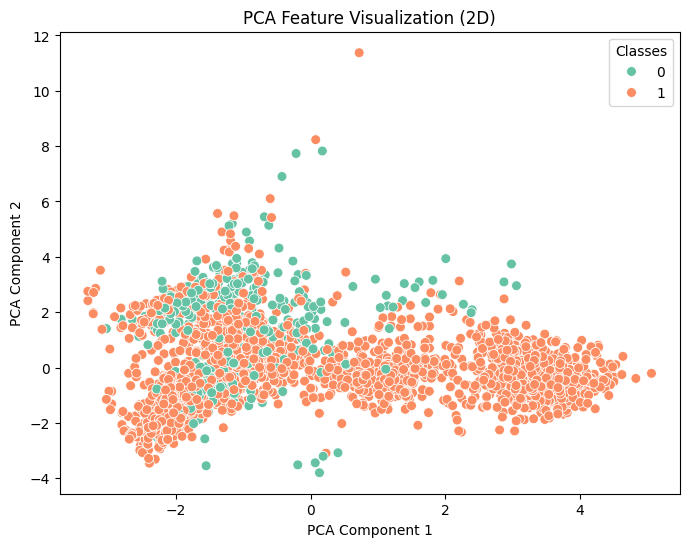

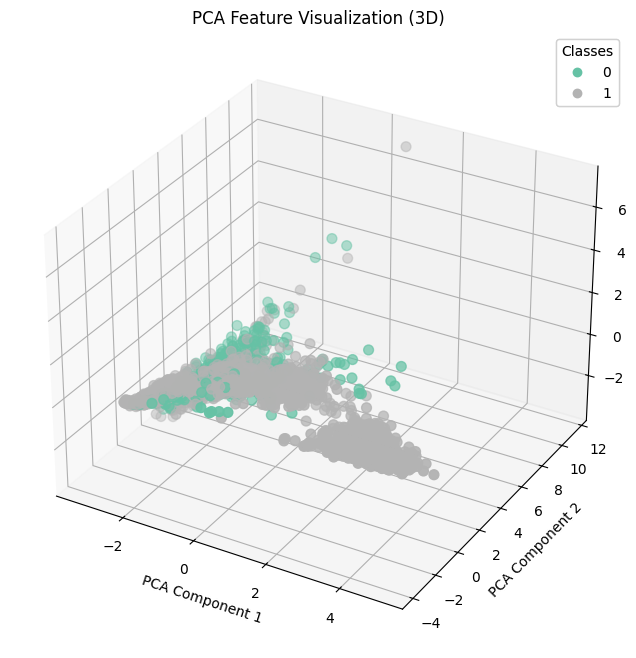

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

def plot_pca_features(model, dataloader, num_components=2):
    """
    Extract features using the model, transform them with PCA, and plot in 2D/3D.
    """
    model.eval()
    features = []
    labels = []

    # Extract features and labels
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(next(model.parameters()).device)
            x = model.extract_features(inputs)
            features.append(x.cpu().numpy())
            labels.append(targets.cpu().numpy())

    # Combine all features and labels
    features = np.vstack(features)
    labels = np.concatenate(labels)

    # Apply PCA for visualization
    pca = PCA(n_components=num_components)
    transformed_features = pca.fit_transform(features)

    # 2D Plot
    if num_components == 2:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            x=transformed_features[:, 0],
            y=transformed_features[:, 1],
            hue=labels,
            palette="Set2",
            s=50,
        )
        plt.title("PCA Feature Visualization (2D)")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.legend(title="Classes")
        plt.show()

    # 3D Plot
    elif num_components == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection="3d")
        scatter = ax.scatter(
            transformed_features[:, 0],
            transformed_features[:, 1],
            transformed_features[:, 2],
            c=labels,
            cmap="Set2",
            s=50,
        )
        ax.set_title("PCA Feature Visualization (3D)")
        ax.set_xlabel("PCA Component 1")
        ax.set_ylabel("PCA Component 2")
        ax.set_zlabel("PCA Component 3")
        legend = ax.legend(*scatter.legend_elements(), title="Classes")
        ax.add_artist(legend)
        plt.show()
    else:
        raise ValueError("num_components must be 2 or 3 for visualization.")

# Assuming `model` is trained, and `train_loader` or `test_loader` is available
plot_pca_features(model, train_loader, num_components=2)  # 2D plot
plot_pca_features(model, train_loader, num_components=3)  # 3D plot


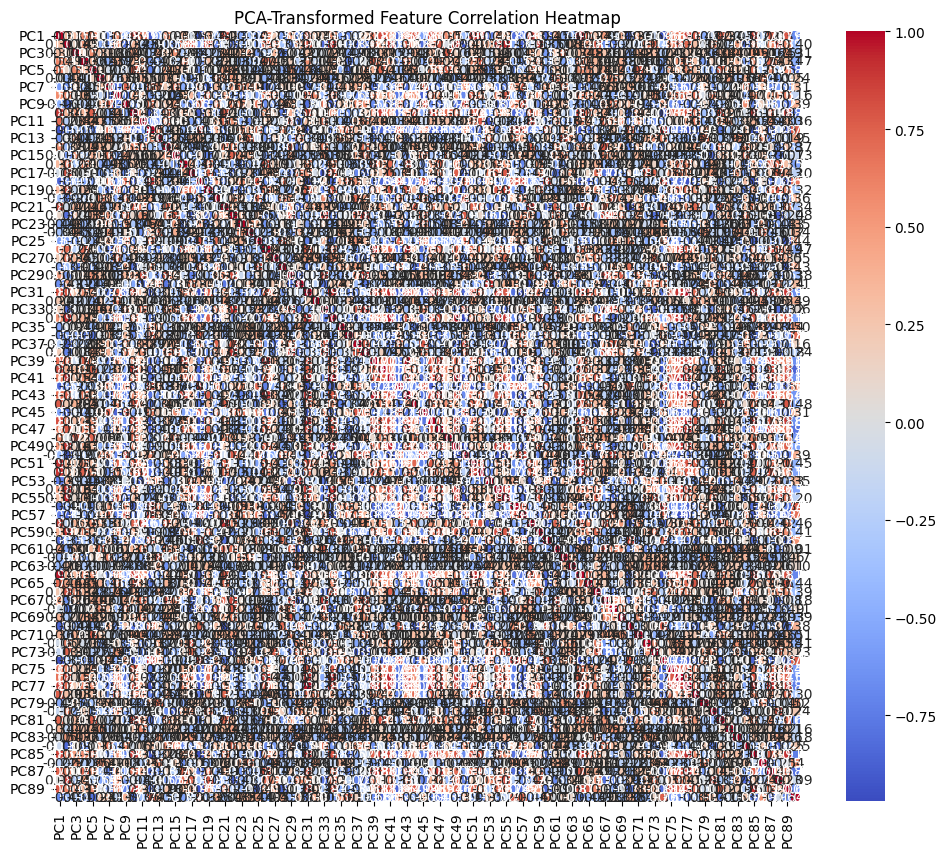

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure the model is in evaluation mode
model.eval()

# Step 1: Extract PCA-Transformed Features from Model
pca_features = []

with torch.no_grad():
    for inputs, _ in train_loader:  # Assuming `train_loader` is defined
        inputs = inputs.to(next(model.parameters()).device)

        # Extract raw features
        raw_features = model.extract_features(inputs)

        # Apply PCA transformation
        transformed_features = model.pca.transform(raw_features.cpu().numpy())
        pca_features.append(transformed_features)

# Combine all features into a single array
pca_features = np.vstack(pca_features)

# Step 2: Create a DataFrame
pca_features_df = pd.DataFrame(pca_features, columns=[f"PC{i+1}" for i in range(pca_features.shape[1])])

# Step 3: Compute Correlation Matrix
correlation_matrix = pca_features_df.corr()

# Step 4: Plot Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
plt.title("PCA-Transformed Feature Correlation Heatmap")
plt.show()
